In [10]:
import pandas as pd
import numpy as np

In [11]:
tods = [1,2,3,4,5]

In [114]:
years = [2018,2019,2020]

In [13]:
df_all = pd.DataFrame()


for year in years:
    print('Working on year ' + str(year))
    if year == 2018:
        months = [11,12]
    elif year == 2020:
        months = [1,2]
    else:
        months = [1,2,3,4,5,6,7,8,9,10,11,12]
        
    for month in months:
        print('Working on month ' + str(month))
        
        for tod in tods:
            print('Working on tod ' + str(tod))

            store = pd.HDFStore('C:/Workspace/TNC-Demand-Model/Outputs/Chicago_TNC_Trips_20.H5')
            df = store.select(where = ['YEAR == ' + str(year), 'MONTH == ' + str(month)], key = 'Weekday_' + str(tod))
            store.close()

            df['TOD'] = tod

            df = df[df['TRIP_LENGTH_MILES'] <= 50]
            df = df[df['TRAVEL_TIME_MINUTES'] <= 120]

            #drop the trips that have a trip length of 0 or travel time of 0 because they do not make sense
            df = df[df['TRIP_LENGTH_MILES'] > 0]
            df = df[df['TRAVEL_TIME_MINUTES'] > 0]

            #filter out the trips that have an unreasonable speed
            df = df[df['SPEED']<120]

            print('Maximum Travel Time')
            print(df['TRAVEL_TIME_MINUTES'].max())

            print('Maximum Trip Length')
            print(df['TRIP_LENGTH_MILES'].max())

            print('Maximum Speed')
            print(df['SPEED'].max())


            #census tract 17031980000 replaces the trips assigned to census tract 17031770700 because they are likely misasigned.
            #Census tract 17031980000 contains contains O'Hare airport and census tract is adjacent. The trips assigned to census tract 17031770700 are likely trips from the airport.
            df.loc[df['ORIGIN'] == 17031770700, 'ORIGIN'] = 17031980000
            df.loc[df['DESTINATION'] == 17031770700, 'DESTINATION'] = 17031980000


            df = df[df['EXTERNAL_FLAGGER'] == 0]
            df = df[df['INTERNAL_EXTERNAL_FLAGGER'] == 0]


            df['PRIVATE_TRIPS'] = np.where(df['SHARED_FLAGGER'] == 0, 1,0)
            df['SHARED_TRIPS'] = np.where(df['SHARED_FLAGGER'] == 1, 1,0)
            df['TRIPS'] = 1

            df = df.groupby(by= ['ORIGIN','DESTINATION','YEAR', 'MONTH','TOD'], as_index =False).sum()

            df_all = df_all.append(df)

df_all = df_all.groupby(by= ['ORIGIN','DESTINATION','YEAR', 'MONTH','TOD'], as_index =False).sum()


Working on year 2018
Working on month 11
Working on tod 1
Maximum Travel Time
118.61666666666666
Maximum Trip Length
50.0
Maximum Speed
118.58823529411762
Working on tod 2
Maximum Travel Time
119.9
Maximum Trip Length
50.0
Maximum Speed
113.87755102040818
Working on tod 3
Maximum Travel Time
119.91666666666667
Maximum Trip Length
50.0
Maximum Speed
113.89090909090909
Working on tod 4
Maximum Travel Time
119.86666666666666
Maximum Trip Length
50.0
Maximum Speed
111.06382978723404
Working on tod 5
Maximum Travel Time
119.71666666666667
Maximum Trip Length
50.0
Maximum Speed
110.76923076923076
Working on month 12
Working on tod 1
Maximum Travel Time
117.8
Maximum Trip Length
50.0
Maximum Speed
111.23595505617978
Working on tod 2
Maximum Travel Time
119.56666666666666
Maximum Trip Length
50.0
Maximum Speed
117.62376237623762
Working on tod 3
Maximum Travel Time
120.0
Maximum Trip Length
50.0
Maximum Speed
116.07476635514018
Working on tod 4
Maximum Travel Time
119.91666666666667
Maximum Tr

Working on tod 4
Maximum Travel Time
120.0
Maximum Trip Length
50.0
Maximum Speed
119.99999999999999
Working on tod 5
Maximum Travel Time
119.21666666666667
Maximum Trip Length
50.0
Maximum Speed
119.79416809605488
Working on month 2
Working on tod 1
Maximum Travel Time
116.36666666666666
Maximum Trip Length
50.0
Maximum Speed
119.99999999999999
Working on tod 2
Maximum Travel Time
119.91666666666667
Maximum Trip Length
50.0
Maximum Speed
119.99999999999999
Working on tod 3
Maximum Travel Time
119.86666666666666
Maximum Trip Length
50.0
Maximum Speed
119.8314606741573
Working on tod 4
Maximum Travel Time
119.86666666666666
Maximum Trip Length
50.0
Maximum Speed
119.66759002770084
Working on tod 5
Maximum Travel Time
118.21666666666667
Maximum Trip Length
50.0
Maximum Speed
119.99999999999999


In [14]:

weekday = pd.read_csv('C:/Workspace/TNC-Demand-Model/Outputs/Number of Weekdays.csv')

df2 = df_all.merge(weekday, on = ['YEAR','MONTH'])


df2['AVG_WD_TRIPS'] = df2['TRIPS']/df2['WEEKDAYS']
df2['AVG_WD_PRIVATE_TRIPS'] = df2['PRIVATE_TRIPS']/df2['WEEKDAYS']
df2['AVG_WD_SHARED_TRIPS'] = df2['SHARED_TRIPS']/df2['WEEKDAYS']


In [16]:
df2[['AVG_WD_TRIPS','MONTH','YEAR']].groupby(by = ['MONTH','YEAR']).sum()

AVG_WD_TRIPS
MONTH YEAR               
1     2019  234341.086956
      2020  230544.521738
2     2019  262441.099999
      2020  250590.249999
3     2019  271187.285716
4     2019  252499.090908
5     2019  253903.434782
6     2019  245274.549999
7     2019  235995.739130
8     2019  241552.499999
9     2019  234227.904763
10    2019  244649.565217
11    2018  241531.045453
      2019  249430.857144
12    2018  223088.904763
      2019  242151.272726

In [17]:
df2.to_csv('C:/Workspace/TNC-Demand-Model/Outputs/OBS_AVG_WD_TRIPS.csv')

In [19]:
airport_tracts = [17031980000,17031980100]
tourist_tracts = [17031081402,17031330100,17031841000]
downtown_tracts = pd.read_csv('C:/Workspace/TNC-Demand-Model/Inputs/Chicago Ride-Hailing/Downtown Zone Census Tracts.csv')
downtown_tracts = list(downtown_tracts['geoid10'])

In [20]:
downtown_tracts.remove(17031081402)

In [29]:
df2.TRIPS.sum()

84799888

In [33]:
df2[df2['DESTINATION'].isin(downtown_tracts)]['TRIPS'].sum()/weekday.WEEKDAYS.sum()

86823.1469740634

In [34]:
df2[df2['DESTINATION'].isin(downtown_tracts)]['TRIPS'].sum()/df2.TRIPS.sum()

0.35527914848189424

In [35]:
df2[df2['DESTINATION'].isin(tourist_tracts)]['TRIPS'].sum()/weekday.WEEKDAYS.sum()

5863.910662824207

In [36]:
df2[df2['DESTINATION'].isin(tourist_tracts)]['TRIPS'].sum()/df2.TRIPS.sum()

0.023995043484019696

In [37]:
df2[df2['DESTINATION'].isin(airport_tracts)]['TRIPS'].sum()/weekday.WEEKDAYS.sum()

9607.337175792507

In [38]:
df2[df2['DESTINATION'].isin(airport_tracts)]['TRIPS'].sum()/df2.TRIPS.sum()

0.03931309437578503

In [39]:
df2[(~df2['DESTINATION'].isin(airport_tracts+tourist_tracts+downtown_tracts))]['TRIPS'].sum()/weekday.WEEKDAYS.sum()

142085.68587896254

In [40]:
df2[(~df2['DESTINATION'].isin(airport_tracts+tourist_tracts+downtown_tracts))]['TRIPS'].sum()/df2.TRIPS.sum()

0.581412713658301

In [45]:
import seaborn as sns

In [42]:
dist = pd.read_csv('C:/Workspace/TNC-Demand-Model/Outputs/Distance_Matrix.csv')

In [43]:
obs_dist = df2.merge(dist, how = 'left', on = ['ORIGIN','DESTINATION'])

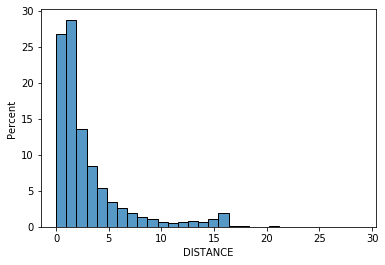

In [46]:
sns.histplot(data = obs_dist, x = 'DISTANCE', bins = 30, weights = 'AVG_WD_TRIPS', stat = 'percent')

In [47]:
np.sum(obs_dist['DISTANCE']*obs_dist['TRIPS'])/obs_dist['TRIPS'].sum()

2.9996755451653097

In [88]:
df2.TRIPS.sum()

84799888

In [48]:
df2[df2['ORIGIN'].isin(downtown_tracts)]['TRIPS'].sum()/weekday.WEEKDAYS.sum()

84745.34870317004

In [49]:
df2[df2['ORIGIN'].isin(downtown_tracts)]['TRIPS'].sum()/df2.TRIPS.sum()

0.3467768259316569

In [50]:
df2[df2['ORIGIN'].isin(tourist_tracts)]['TRIPS'].sum()/weekday.WEEKDAYS.sum()

6352.319884726225

In [51]:
df2[df2['ORIGIN'].isin(tourist_tracts)]['TRIPS'].sum()/df2.TRIPS.sum()

0.025993607444387192

In [52]:
df2[df2['ORIGIN'].isin(airport_tracts)]['TRIPS'].sum()/weekday.WEEKDAYS.sum()

7470.466858789626

In [53]:
df2[df2['ORIGIN'].isin(airport_tracts)]['TRIPS'].sum()/df2.TRIPS.sum()

0.030569049808178993

In [54]:
df2[(~df2['ORIGIN'].isin(airport_tracts+tourist_tracts+downtown_tracts))]['TRIPS'].sum()/weekday.WEEKDAYS.sum()

145811.94524495676

In [55]:
df2[(~df2['ORIGIN'].isin(airport_tracts+tourist_tracts+downtown_tracts))]['TRIPS'].sum()/df2.TRIPS.sum()

0.5966605168157769

In [57]:
df2.TRIPS.sum()

84799888

In [86]:
df2[df2['TOD'] == 1]['TRIPS'].sum()/weekday.WEEKDAYS.sum()

37082.20172910663

In [76]:
df2[df2['TOD'] == 2]['TRIPS'].sum()/weekday.WEEKDAYS.sum()

34269.78962536023

In [77]:
df2[df2['TOD'] == 3]['TRIPS'].sum()/weekday.WEEKDAYS.sum()

78061.41786743516

In [78]:
df2[df2['TOD'] == 4]['TRIPS'].sum()/weekday.WEEKDAYS.sum()

48630.452449567725

In [79]:
df2[df2['TOD'] == 5]['TRIPS'].sum()/weekday.WEEKDAYS.sum()

46336.21902017291